In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.manifold import TSNE

# dataset coming from 1_Preprocessing with already sbert embeddings in a column
df = pd.read_pickle("path/New_Preprocessed_Dataset.pkl")

pd.set_option('display.max_colwidth', None)

In [2]:
# rename label : none to normal
df['label'] = df['label'].replace('none', 'normal')

### Word Cloud

In [3]:
full_text = df['text'].values
racist_text = df[df['label'] == 'racism']['text'].values
sexist_text = df[df['label'] == 'sexism']['text'].values

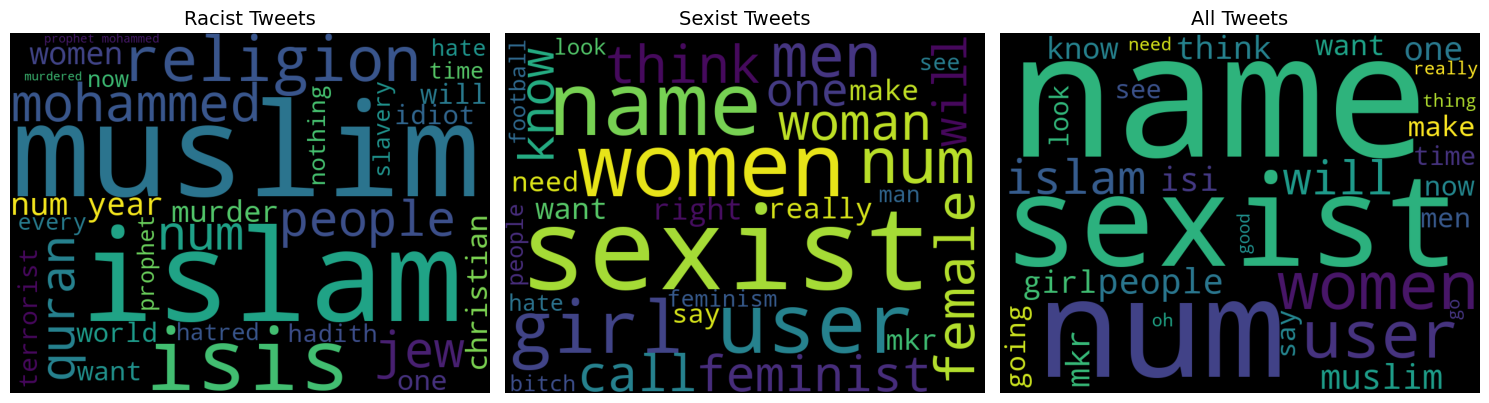

In [4]:
def generate_wordcloud(text):
    return WordCloud(
        background_color='black',
        width=800,  
        height=600,
        max_words=30
    ).generate(" ".join(text))

racist_cloud = generate_wordcloud(racist_text)
sexist_cloud = generate_wordcloud(sexist_text)
full_cloud = generate_wordcloud(full_text)

# Plot them side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Titles for each subplot
titles = ["Racist Tweets", "Sexist Tweets", "All Tweets"]
clouds = [racist_cloud, sexist_cloud, full_cloud]

for ax, cloud, title in zip(axes, clouds, titles):
    ax.imshow(cloud)
    ax.set_title(title, fontsize=14, color="black") 
    ax.axis('off')

plt.tight_layout()
plt.show()

### SBERT

In [ ]:
# embeddings SBERT already computed in preprocessing notebook
embeddings = np.array(df['embedding'].tolist())
labels = df['label'].tolist()

# dimension reduction to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# plot
plt.figure(figsize=(6, 4))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=[{'normal':0, 'sexism':1, 'racism':2}[lbl] for lbl in labels], cmap='coolwarm', alpha=0.7)
plt.colorbar(label="Classes")
plt.title("SBERT embeddings with t-SNE")
plt.show()

### GLOVE

In [ ]:
# Load GloVe model
def load_glove_model(File):
    print("Loading Glove Model")
    glove_model = {}
    with open(File, 'r', encoding='utf-8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model

glove_model=load_glove_model("path/glove.6B.200d.txt")

Loading Glove Model
400000 words loaded!


In [ ]:
# Create GloVe embeddings
df_glove = df.copy()

dim = glove_model["the"].shape[0]
def get_glove_embeddings(text):
    text = str(text)
    text = text.split()
    text = [word for word in text if word in glove_model]
    if len(text)==0:
        return np.zeros(dim)
    else:
        return np.mean(np.array([glove_model[word] for word in text]),axis=0)

df_glove['embeddings'] = df_glove['text'].apply(lambda text: get_glove_embeddings(text))
data_glove = pd.concat([df_glove, df_glove['embeddings'].apply(pd.Series)], axis=1).dropna()

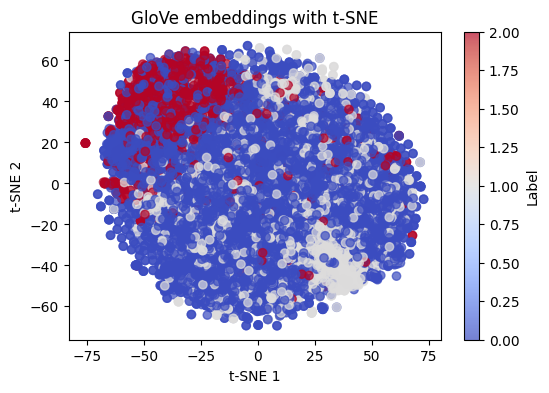

In [ ]:
# apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(np.array(data_glove['embeddings'].tolist()))

# Visualisation
plt.figure(figsize=(6, 4))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=[{'normal':0, 'sexism':1, 'racism':2}[lbl] for lbl in data_glove["label"]], cmap="coolwarm", alpha=0.7)
plt.colorbar(scatter, label="Label")
plt.title("GloVe embeddings with t-SNE")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

### Word2Vec

In [10]:
from gensim.models import Word2Vec

df_w2c = df.copy()
text_list = df_w2c['text'].tolist()
annotations = df_w2c['label'].tolist()

In [ ]:
w2v_model = Word2Vec(sentences=text_list, vector_size=400, window=5, min_count=1, workers=8, sg=1, negative=10, epochs = 100)

# obtain mean vector for each sentence
def sentence_to_vector(sentence, model):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

In [12]:
sentence_vectors = []
labels = []

for sentence, label in zip(text_list, annotations):
    vector = sentence_to_vector(sentence, w2v_model)
    if vector is not None:  # Ensure valid vector
        sentence_vectors.append(vector)
        labels.append(label)

sentence_vectors = np.array(sentence_vectors)
labels = np.array(labels)

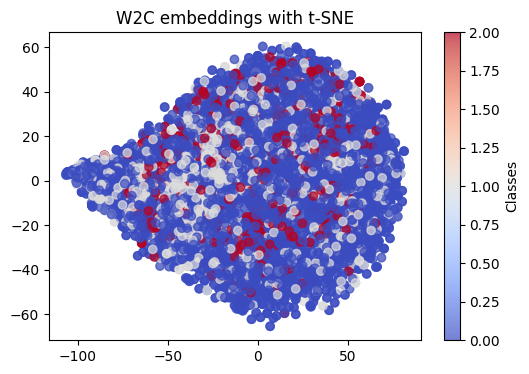

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(sentence_vectors)

# Visualisation of Word2Vec embeddings
plt.figure(figsize=(6, 4))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=[{'normal':0, 'sexism':1, 'racism':2}[lbl] for lbl in labels], cmap='coolwarm', alpha=0.7)
plt.colorbar(label="Classes")
plt.title("W2C embeddings with t-SNE")
plt.show()

### BoW

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_df=.6, min_df=.1)

In [15]:
df_bow = df.copy()
df_bow['embedding'] = list(vectorizer.fit_transform(df_bow['text']).toarray())

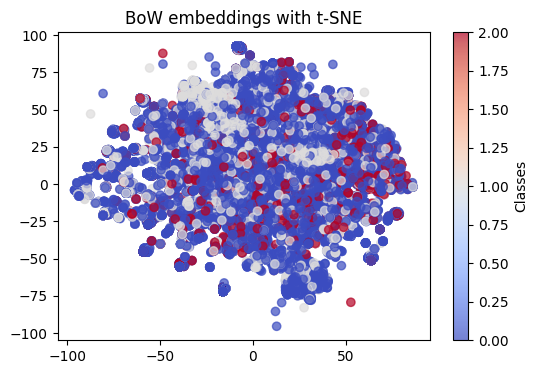

In [ ]:
embeddings = np.array(df_bow['embedding'].tolist()) 
labels = df_bow['label'].tolist()

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Visualisation
plt.figure(figsize=(6, 4))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=[{'normal':0, 'sexism':1, 'racism':2}[lbl] for lbl in labels], cmap='coolwarm', alpha=0.7)
plt.colorbar(label="Classes")
plt.title("BoW embeddings with t-SNE")
plt.show()

### TF-IDF

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=.6, min_df=.1)

In [18]:
df_tfidf = df.copy()
df_tfidf['embedding'] = list(vectorizer.fit_transform(df_tfidf['text']).toarray())

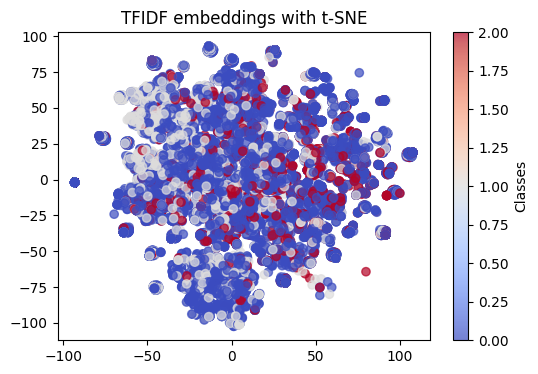

In [ ]:
embeddings = np.array(df_tfidf['embedding'].tolist())  
labels = df_tfidf['label'].tolist() 

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Visualisation
plt.figure(figsize=(6, 4))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=[{'normal':0, 'sexism':1, 'racism':2}[lbl] for lbl in labels], cmap='coolwarm', alpha=0.7)
plt.colorbar(label="Classes")
plt.title("TFIDF embeddings with t-SNE")
plt.show()